# Disjunctive Programming
Let's compare two different approaches to disjunctive programming: Big-M and convex hull. 

## A simple problem
minimize $ x^\top Q x + q^\top x $

subject to:
$$
\begin{aligned}
x \in R_1 \cup R_2\\
x_{lb} \leq x \leq x_{ub}
\end{aligned}
$$

where $R_i$ is a polyhedron specified by
$$
R_i \equiv \{ x\  |\  A_i x \leq b_i \}
$$

## Binary variables
We'll rewrite the above problem by introducing binary variables $z_i$:

minimize $ x^\top Q x + q^\top x $

over $x$, $z_i$

subject to:
$$
\begin{aligned}
z_1 = 1 \implies x \in R_1\\
z_2 = 1 \implies x \in R_2\\
z_i \in \{0, 1\}\\
\sum_i z_i = 1\\
x_{lb} \leq x \leq x_{ub}
\end{aligned}
$$


## Big-M
The big-M formulation lets us convert the implies operators into linear constraints:

$$
z_i = 1 \implies x \in R_i
$$

becomes

$$
A_i x + M z_i \leq b_i + M
$$

If M is sufficiently big, then when $z_i$ is $0$, the constraint becomes trivial, and when $z_i$ is $1$, the constraint becomes exactly $x \in R_1$. 


# Implementation

The following code was developed in Julia v0.6 using the following packages:

In [1]:
# To install the QHull package, run:
# Pkg.clone("git@github.com:davidavdav/QHull.jl")
using QHull
using PyPlot
using JuMP
using Gurobi

# Automatically display the installed versions of
# each of the above packages
for pkg in ["QHull", "PyPlot", "JuMP", "Gurobi"]
    println((pkg, Pkg.installed(pkg)))
end

("QHull", v"0.0.0-")
("PyPlot", v"2.3.2")
("JuMP", v"0.17.1")
("Gurobi", v"0.3.3")



## Generating regions
We'll generate the regions as the convex hull of some random points:

In [2]:
"""
Given N points as an N x dim matrix P,
return a new matrix of size (N + 1) x dim
points giving a counter-clockwise convex path
around the convex hull of the points.
"""
function hull_points(P::Array{Float64,2})
    hull = chull(P)
    P[[hull.vertices..., hull.vertices[1]], :]
end

hull_points

In [3]:
dim = 2
num_regions = 2
P = Vector{Matrix{Float64}}()
A = Vector{Matrix{Float64}}()
b = Vector{Vector{Float64}}()
R = [0 1; -1 0]

for j in 1:num_regions
    P_unordered = rand(4, dim) .+ [j 0]
    push!(P, hull_points(P_unordered))
    push!(A, zeros(size(P[j], 1) - 1, size(P[j], 2)))
    push!(b, zeros(size(A[j], 1)))
    for i in 1:(size(P[j], 1) - 1)
        v = P[j][i+1, :] - P[j][i, :]
        
        A[j][i,:] = (R * v)
        normalize!(A[j][i,:])
        b[j][i] = A[j][i,:]' * P[j][i,:]
    end
end
x_lb = 0
x_ub = num_regions + 2
x_goal = [num_regions / 2 + 1; 1.5]

2-element Array{Float64,1}:
 2.0
 1.5

In [4]:
bigM = Model(solver=GurobiSolver())

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is Gurobi

In [5]:
@variable(bigM, x_lb <= x[1:dim] <= x_ub)

2-element Array{JuMP.Variable,1}:
 x[1]
 x[2]

In [6]:
@variable(bigM, z[1:num_regions], Bin)

2-element Array{JuMP.Variable,1}:
 z[1]
 z[2]

In [7]:
@constraint(bigM, sum(z) == 1)

z[1] + z[2] = 1

In [8]:
M = 100
for i in 1:num_regions
    @constraint(bigM, A[i] * x .+ M * z[i] .<= b[i] .+ M)
end


In [9]:
@objective(bigM, Min, sum((x - x_goal).^2))

:Min

In [10]:
bigM

Minimization problem with:
 * 8 linear constraints
 * 4 variables: 2 binary
Solver is Gurobi

In [11]:
status = solve(bigM)

Optimize a model with 8 rows, 4 columns and 23 nonzeros
Model has 2 quadratic objective terms
Variable types: 2 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+02]
  Objective range  [3e+00, 4e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 7 rows, 3 columns, 21 nonzeros
Presolved model has 2 quadratic objective terms
Variable types: 2 continuous, 1 integer (1 binary)

Root relaxation: objective -5.941797e+00, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -5.94180    0    1          -   -5.94180      -     -    0s
H    0     0                      -5.5925502   -5.94180  6.24%     -    0s
H    0     0                      -5.9092570   -5.94180  0.55%     -    0s
     0     0  

:Optimal

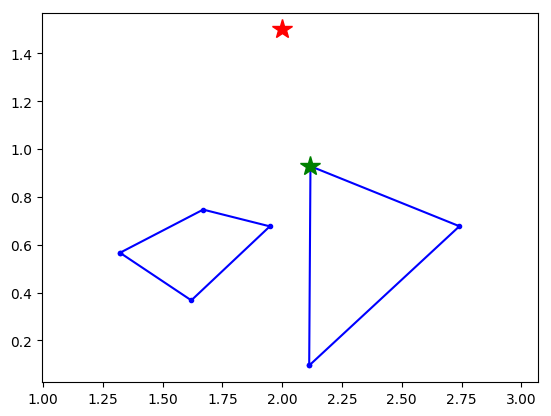

(1.2510058226733667, 2.8118874440919366, 0.025060818899761236, 1.5702351991000114)

In [12]:
figure()
for j in 1:num_regions
    plot(P[j][:,1], P[j][:,2], "b.-")
end
plot([getvalue(x[1])], [getvalue(x[2])], "g*", markersize=15, markerfacecolor="g")
plot([x_goal[1]], [x_goal[2]], "r*", markersize=15)
axis("equal")

## Convex Hull formulation
minimize $ x^\top Q x + q^\top x $

subject to:
$$
\begin{aligned}
v &= u_1 + u_2\\
A_1 u_1 &\leq y_1 b_1\\
A_2 u_2 &\leq y_2 b_2\\
y_1 x_{lb} &\leq u_1 \leq y_1 x_{ub}\\
y_2 x_{lb} &\leq u_2 \leq y_2 x_{ub}\\
y_i &\in \{0, 1\}
\end{aligned}
$$

where $R_i$ is a polyhedron specified by
$$
R_i \equiv \{ x\  |\  A_i x \leq b_i \}
$$




In [13]:
conv = Model(solver=GurobiSolver())

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is Gurobi

In [14]:
@variable(conv, v[1:dim])

2-element Array{JuMP.Variable,1}:
 v[1]
 v[2]

In [15]:
@variable(conv, u[1:num_regions, 1:dim])

2×2 Array{JuMP.Variable,2}:
 u[1,1]  u[1,2]
 u[2,1]  u[2,2]

In [16]:
@variable(conv, y[1:num_regions], Bin)

2-element Array{JuMP.Variable,1}:
 y[1]
 y[2]

In [17]:
@constraint(conv, sum(y) == 1)

y[1] + y[2] = 1

In [18]:
for i in 1:num_regions
    @constraint(conv, A[i] * u[i,:] .<= y[i] .* b[i])
end

In [19]:
for i in 1:num_regions
    @constraint(conv, y[i] * x_lb .<= u[i,:])
    @constraint(conv, u[i,:] .<= y[i] * x_ub)
end

In [20]:
@constraint(conv, v .== sum(u[i, :] for i=1:num_regions))

2-element Array{JuMP.ConstraintRef{JuMP.Model,JuMP.GenericRangeConstraint{JuMP.GenericAffExpr{Float64,JuMP.Variable}}},1}:
 v[1] - u[1,1] - u[2,1] = 0
 v[2] - u[1,2] - u[2,2] = 0

In [21]:
@objective(conv, Min, sum((v - x_goal).^2))

:Min

In [22]:
conv

Minimization problem with:
 * 18 linear constraints
 * 8 variables: 2 binary
Solver is Gurobi

In [23]:
status = solve(conv)

Optimize a model with 18 rows, 8 columns and 41 nonzeros
Model has 2 quadratic objective terms
Variable types: 6 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [5e-03, 4e+00]
  Objective range  [3e+00, 4e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 7 rows and 1 columns
Presolve time: 0.00s
Presolved: 11 rows, 7 columns, 31 nonzeros
Presolved model has 2 quadratic objective terms
Variable types: 6 continuous, 1 integer (1 binary)

Root relaxation: objective -5.909257e+00, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      -5.9092570   -5.90926  0.00%     -    0s

Explored 0 nodes (16 simplex iterations) in 0.00 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: -5.90926 
Pool objective bound -5.909

:Optimal

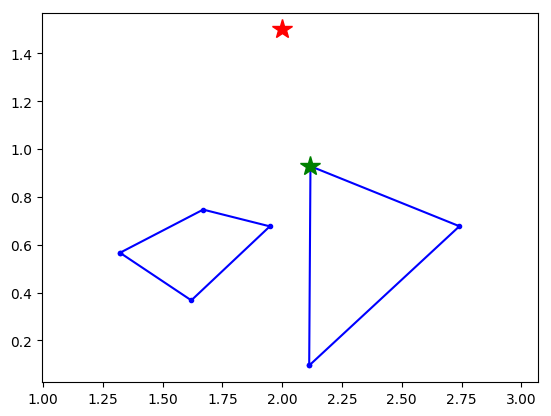

(1.2510058226733667, 2.8118874440919366, 0.025060818899761236, 1.5702351991000114)

In [24]:
figure()
for j in 1:num_regions
    plot(P[j][:,1], P[j][:,2], "b.-")
end
plot([getvalue(v[1])], [getvalue(v[2])], "g*", markersize=15, markerfacecolor="g")
plot([x_goal[1]], [x_goal[2]], "r*", markersize=15)
axis("equal")